Practice on titanic dataset

The page MBAN 6110 S - Data Science I has been updated.
Cheatsheet Data Modelling Process
The following should help provide guidance for completing the exam. 
1. Import data - you will need to use the pd.read_csv() function to import the provided data set 
2. Dataframe checks - use df.info() and df.describe() to understand your data 
        * using df.info(), look for the following: 
        * missing data 
        * incorrect data type (i.e., a column looks like a number but the data type in df.info() says it's an object)
        > this means there are data issues (special characters, text where it shouldn't be, etc.) 
        * using df.describe(), look for the following: 
        * do the ranges make sense? * are there outliers? 
        * which variables are categorical (even if there is a number indicator, like 1,2,3) 
        * which variables are continuous 
3. Data cleaning 
        * clean missing values 
        * check how much of the TOTAL data is missing. If less than 10% of the total data points, then drop the missing data 
        * if more than 10%: 
        * Compare filling methods: Average/Median of the column OR Average/median of the column based on a category. Select the method that doesn't cause drastic differences in results 
        * Explain your choice. Make sure that you have checked both methods before finalizing your choice.  
4. Data exploration 
        * Check EACH variable thoroughly 
        * for continuous variables: plot the boxplots with the x-axis as the output variable, and y-axis as the continuous variable 
        * You are looking for difference in spread of data. For example, if output category 0 has a spread of 10-50, but output category 1 has a spread of 25-70, obviously the continuous variable depends differently depending on the output. So this would indicate that this variable is meaningful to the analysis. 
        * for categorical variables: use groupby() to check proportions 
        * Check whether the independent variable categories have different proportions to the dependent variable. For example, when comparing the titanic survival by gender, the first categorical variable is Gender and we're comparing it to a categorical output "Survived" - if we see that a higher proportion of Survivors are Women,  vs. the proportion of survivors who were women, then we can conclude gender has something to do with survival. 
5. Feature engineering 
        * Generate new features from the data you have. This could include: 
        * binning (i.e., translate a continuous variable into groups like 5-10, 15-20, etc.) 
        * dummy variables (use one hot encoding, or pandas get_dummies() function to convert categorical variables to dummies) 
        * define new metrics (e.g., multiply columns together or create custom categories based on multiple variables) 
        * Check the relationship of engineered features to the output variable, using the methods outlined above 6. Data model 
        * build a baseline set of models using the data from your exploratory analysis which seems to have a relationship with the output variable. For a categorical problem, build a baseline model from each model we learned in class > Logistic Regression, Naive Bayes, KNN, SVM, Decision Tree. Use the cross validation function to run each model 10 times and calculate an average performance. Remember to use F1 score in the cross validation function.
        * Select the model that has the best F1 score overall. Now you will work on optimizing this model. 
        * Decide whether you want to optimize based on Precision or Recall. You will need to explain your choice in relation to the business objective.  
        * Tune the model using hyperparameter tuning. If your computer doesn't have much memory, use RandomSearchCV with the n_iter parameter set to a low number like 100 
        * Check performance metrics: precision, recall, F1 score, roc_auc, accuracy score 
        * If your model isn't performing well, try adding/removing variables, or engineering more features 
        * Once you're confident you have tried everything possible to build the best possible model, you can finalize your model 7. Explaining your results 
        * Explain your results by always connecting your decisions to the business problem provided. 
        * Explain your process > how did you decide to clean the data? how do you know that was the best decision? what did you learn from exploratory analysis, and how did this inform your modelling decisions? Which features did you engineer? how did you pick these?  
        * Explain the final model > which variables were included in the model, and what was the model performance? 
        * Explain how this model can be applied to the future to predict outcomes > how will the business use the model? 


In [474]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import warnings

In [475]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')

In [476]:
df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
214,215,0,3,"Kiernan, Mr. Philip",male,NaN,1,0,367229,7.7500,NaN,Q
220,221,1,3,"Sunderland, Mr. Victor Francis",male,16.0,0,0,SOTON/OQ 392089,8.0500,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
171,172,0,3,"Rice, Master. Arthur",male,4.0,4,1,382652,29.1250,NaN,Q
521,522,0,3,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S


In [477]:
df.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

In [478]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [479]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292
Embarked,889,3,S,644,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [480]:
df.dropna(inplace=True)

In [481]:
df.drop_duplicates(inplace=True)

In [482]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 674 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  674 non-null    int64  
 1   Pclass    674 non-null    int64  
 2   Sex       674 non-null    object 
 3   Age       674 non-null    float64
 4   SibSp     674 non-null    int64  
 5   Parch     674 non-null    int64  
 6   Fare      674 non-null    float64
 7   Embarked  674 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 47.4+ KB


In [483]:
sex = pd.get_dummies(df['Sex'],dtype=int)
pd.concat([df,sex],axis=1)
df.drop(['Sex'],axis=1,inplace=True)

In [484]:
Embarked = pd.get_dummies(df['Embarked'],dtype=int)
pd.concat([df,Embarked],axis=1)
df.drop(['Embarked'],axis=1,inplace=True)

In [485]:
df['Survived'].unique()

array([0, 1], dtype=int64)

In [486]:
# univariate analysis - first we check the output variable and make sure it's balanced
df.groupby('Survived').count()

,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,
0,393,393,393,393,393
1,281,281,281,281,281


In [487]:
# ratio is
60*100 / (122+60)

32.967032967032964

thats decently balanced dataset. so planning to skip smote

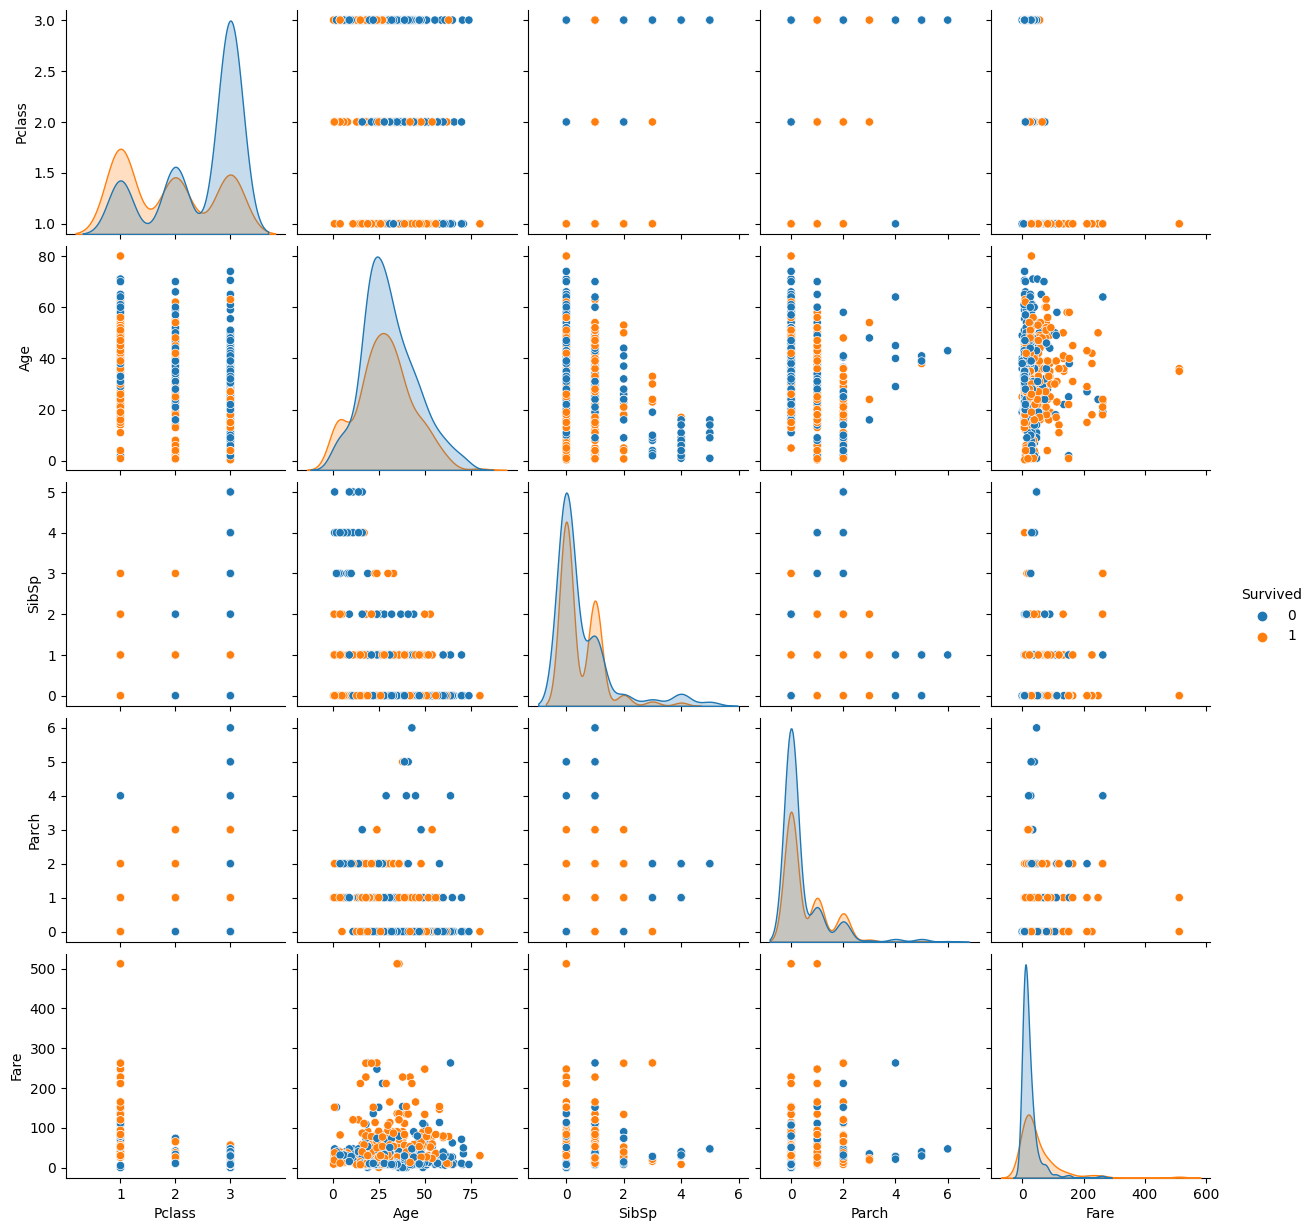

In [488]:
sns.pairplot(df,hue = 'Survived')

In [489]:
df.drop(df[df['Fare']>=450].index,axis=0,inplace=True)

In [490]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
Survived,671.0,0.414307,0.492969,0.00,0.00,0.0,1.000,1.0
Pclass,671.0,2.230999,0.843938,1.00,1.00,2.0,3.000,3.0
Age,671.0,29.727899,14.721242,0.42,20.00,28.0,39.000,80.0
SibSp,671.0,0.539493,0.948450,0.00,0.00,0.0,1.000,5.0
Parch,671.0,0.456036,0.872852,0.00,0.00,0.0,1.000,6.0
Fare,671.0,33.589692,43.799287,0.00,8.05,16.1,34.375,263.0


change of data type using astype

In [491]:
df.Age=df.Age.astype('int')

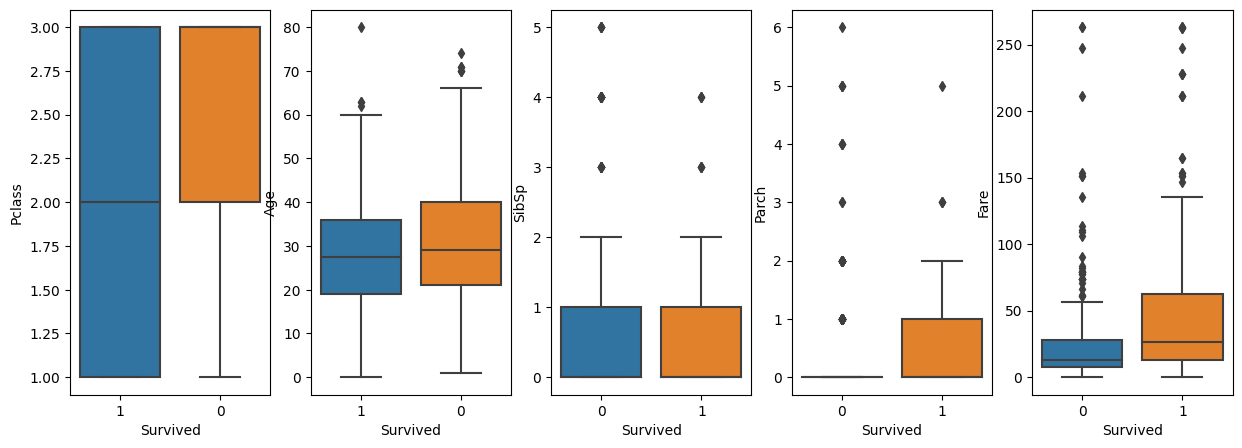

In [492]:
median_1 = df.groupby('Survived')['Pclass'].median()
median_2 = df.groupby('Survived')['Age'].median()
median_3 = df.groupby('Survived')['SibSp'].median()
median_4 = df.groupby('Survived')['Parch'].median()
median_5 = df.groupby('Survived')['Fare'].median()

sorted_1 = median_1.sort_values().index
sorted_2 = median_2.sort_values().index
sorted_3 = median_3.sort_values().index
sorted_4 = median_4.sort_values().index
sorted_5 = median_5.sort_values().index

fig, (ax1, ax2, ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(15, 5))
sns.boxplot(x='Survived', y='Pclass', data=df, order=sorted_1, ax=ax1)
sns.boxplot(x='Survived', y='Age', data=df, order=sorted_2, ax=ax2)
sns.boxplot(x='Survived', y='SibSp', data=df, order=sorted_3, ax=ax3)
sns.boxplot(x='Survived', y='Parch', data=df, order=sorted_3, ax=ax4)
sns.boxplot(x='Survived', y='Fare', data=df, order=sorted_3, ax=ax5)
plt.show()

In [493]:
df.groupby(['Parch','Survived'])['Fare'].count().unstack()

Survived,0,1
Parch,,
0,304.0,176.0
1,49.0,59.0
2,29.0,39.0
3,2.0,3.0
4,4.0,NaN
5,4.0,1.0
6,1.0,NaN


In [494]:
df.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

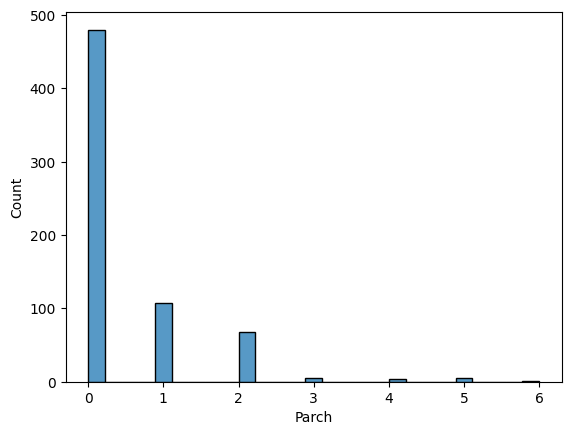

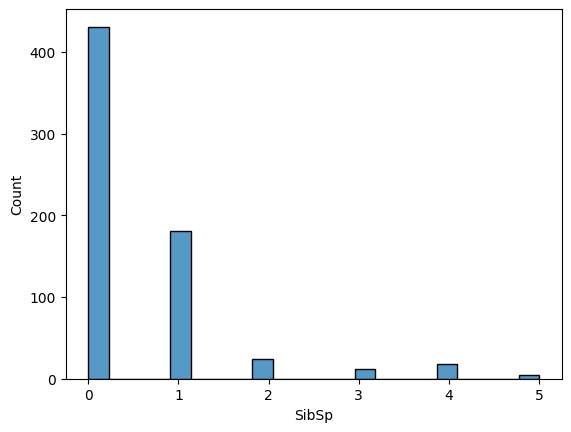

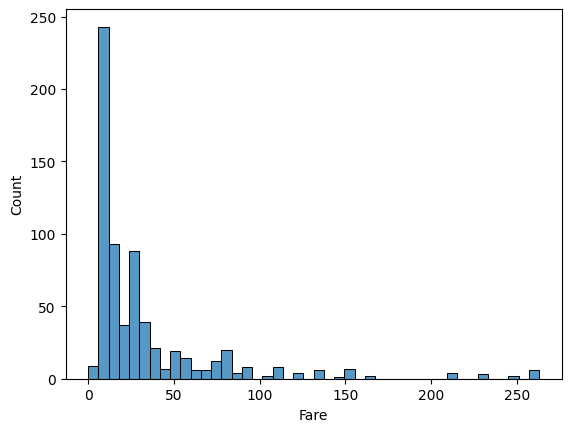

In [495]:
sns.histplot(df['Parch'])
plt.show()
sns.histplot(df['SibSp'])
plt.show()
sns.histplot(df['Fare'])
plt.show()

'00'number of varaibles explain the target value by 90%

In [496]:
dc = df.corr()
dc['Survived'].sort_values(ascending=False).index

Index(['Survived', 'Fare', 'Parch', 'SibSp', 'Age', 'Pclass'], dtype='object')

<Axes: >

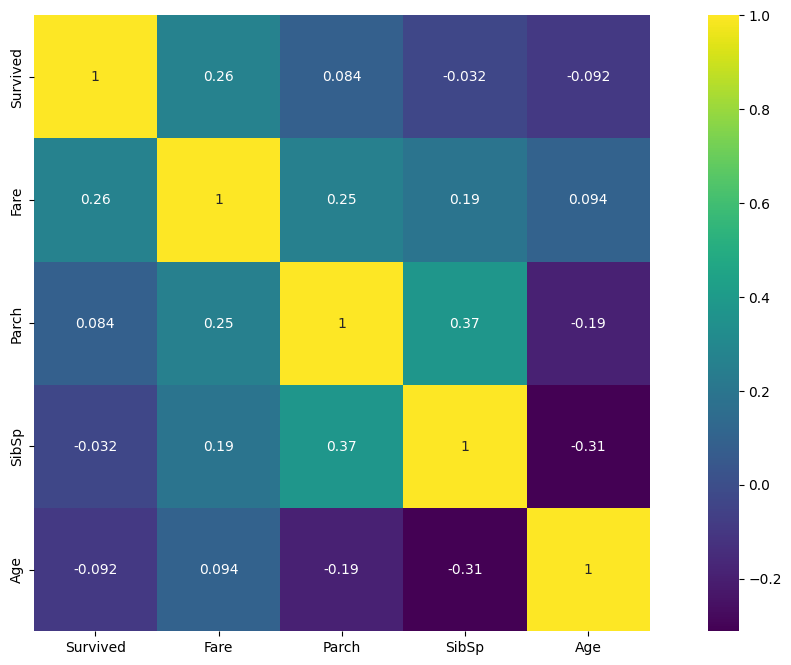

In [497]:
 
df=df[['Survived', 'Fare', 'Parch', 'SibSp', 'Age']]
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(),annot=True,cmap='viridis', square=True)

In [498]:
df.describe(include='all')

,Survived,Fare,Parch,SibSp,Age
count,671.000000,671.000000,671.000000,671.000000,671.000000
mean,0.414307,33.589692,0.456036,0.539493,29.707899
std,0.492969,43.799287,0.872852,0.948450,14.729539
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8.050000,0.000000,0.000000,20.000000
50%,0.000000,16.100000,0.000000,0.000000,28.000000
75%,1.000000,34.375000,1.000000,1.000000,39.000000
max,1.000000,263.000000,6.000000,5.000000,80.000000


<Axes: xlabel='Age', ylabel='Count'>

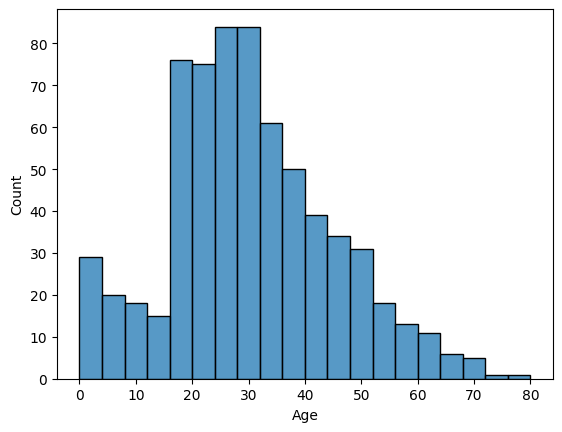

In [499]:
sns.histplot(df['Age'],bins=20)

In [500]:
def categorize_Age(Age):
    if Age > 60:
        return "High"
    elif 40 <= Age <= 60:
        return "Medium 1"
    elif 20 <= Age <= 40:
        return "Medium_2"
    else:
        return "Low"

df['Age_cat'] = df['Age'].apply(categorize_Age)

In [501]:
df.groupby('Age_cat')['Survived'].count()

Age_cat
High         20
Low         158
Medium 1    139
Medium_2    354
Name: Survived, dtype: int64

In [502]:
df.columns

Index(['Survived', 'Fare', 'Parch', 'SibSp', 'Age', 'Age_cat'], dtype='object')

one hot encoding

In [503]:
df = pd.get_dummies(df, columns=['Age_cat'], prefix='Age',dtype=int)

In [504]:
df.sample(5)

,Survived,Fare,Parch,SibSp,Age,Age_High,Age_Low,Age_Medium 1,Age_Medium_2
378,0,4.0125,0,0,20,0,0,0,1
377,0,211.5000,2,0,27,0,0,0,1
836,0,8.6625,0,0,21,0,0,0,1
707,1,26.2875,0,0,42,0,0,1,0
480,0,46.9000,2,5,9,0,1,0,0


In [505]:
# # splitting cat & num
# cat_columns = ['Age_cat']
# num_columns = ['Fare', 'Parch', 'SibSp']
# target = 'Survived'

# cat_transformer = OneHotEncoder()
# num_transformer = StandardScaler()
# preprocessor = ColumnTransformer(transformers = [('cat',cat_transformer, cat_columns),
#                                                  ('num', num_transformer, num_columns)])

# x_train, x_test, y_train, y_test = train_test_split(df[cat_columns + num_columns], df[target], test_size=0.3, random_state=123)

In [506]:
x=df[['Fare', 'Parch', 'SibSp','Age_High', 'Age_Low','Age_Medium 1', 'Age_Medium_2']]
y=df['Survived']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=123)

In [507]:
df.sample(5)

,Survived,Fare,Parch,SibSp,Age,Age_High,Age_Low,Age_Medium 1,Age_Medium_2
693,0,7.2250,0,0,25,0,0,0,1
450,0,27.7500,2,1,36,0,0,0,1
704,0,7.8542,0,1,26,0,0,0,1
407,1,18.7500,1,1,3,0,1,0,0
824,0,39.6875,1,4,2,0,1,0,0


In [508]:
x_train.shape

(469, 7)

In [509]:
x_test.shape

(202, 7)

both have 7 columns each so the shape is good.

### modelling 

In [510]:
log = LogisticRegression()
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=7)
tree = DecisionTreeClassifier(random_state=123)
svc = SVC(kernel='linear')
models = (log,nb,knn,tree,svc)

In [511]:
warnings.filterwarnings("ignore")

In [512]:
log.fit(x_train,y_train)
nb.fit(x_train,y_train)
knn.fit(x_train,y_train)
tree.fit(x_train,y_train)

DecisionTreeClassifier(random_state=123)

In [513]:
yhat_log = log.predict_proba(x_test)
yhat_nb = nb.predict_proba(x_test)
yhat_knn = knn.predict_proba(x_test)
yhat_tree = tree.predict_proba(x_test)

knn doesnt support probability predict 

In [514]:
y_pred_log = log.predict(x_test)
y_pred_nb = nb.predict(x_test)
y_pred_knn = knn.predict(x_test)
y_pred_tree = tree.predict(x_test)

In [515]:
fpr_log, tpr_log, thresholds_l = roc_curve(y_test, yhat_log[:,1])
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, yhat_nb[:,1])
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, yhat_nb[:,1]) # * 
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, yhat_tree[:,1])

ROC curve overlap

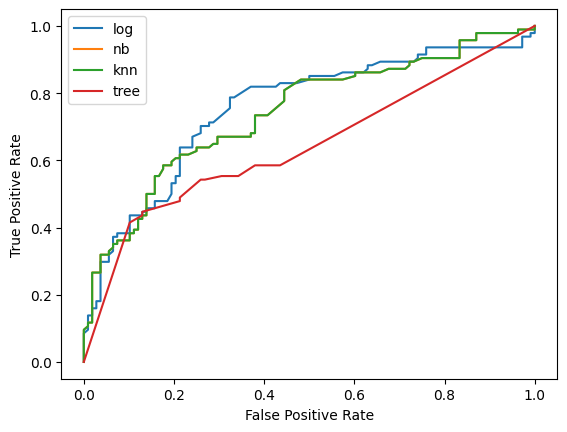

In [516]:
plt.plot(fpr_log,tpr_log, label='log')
plt.plot(fpr_nb,tpr_nb, label='nb')
plt.plot(fpr_knn,tpr_knn, label='knn')
plt.plot(fpr_tree,tpr_tree, label='tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [517]:
metrics = pd.DataFrame(index = ['accuracy','precision', 'recall'], columns =['logisticReg','NaiveBayes','KNN','Tree'])

In [518]:
metrics.loc['accuracy','logisticReg'] = accuracy_score(y_pred=y_pred_log,y_true=y_test)
metrics.loc['precision','logisticReg'] = precision_score(y_pred=y_pred_log,y_true=y_test)
metrics.loc['recall','logisticReg'] = recall_score(y_pred=y_pred_log,y_true=y_test)
print(confusion_matrix(y_pred=y_pred_log,y_true=y_test))
print("Classification Report:")
print(classification_report(y_test,y_pred_log))

[[104   4]
 [ 69  25]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       108
           1       0.86      0.27      0.41        94

    accuracy                           0.64       202
   macro avg       0.73      0.61      0.57       202
weighted avg       0.72      0.64      0.58       202



In [519]:
metrics.loc['accuracy','NaiveBayes'] = accuracy_score(y_pred=y_pred_nb,y_true=y_test)
metrics.loc['precision','NaiveBayes'] = precision_score(y_pred=y_pred_nb,y_true=y_test)
metrics.loc['recall','NaiveBayes'] = recall_score(y_pred=y_pred_nb,y_true=y_test)
print(confusion_matrix(y_pred=y_pred_nb,y_true=y_test))
print("Classification Report:")
print(classification_report(y_test,y_pred_nb))

[[92 16]
 [47 47]]
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74       108
           1       0.75      0.50      0.60        94

    accuracy                           0.69       202
   macro avg       0.70      0.68      0.67       202
weighted avg       0.70      0.69      0.68       202



In [520]:
metrics.loc['accuracy','KNN'] = accuracy_score(y_pred=y_pred_knn,y_true=y_test)
metrics.loc['precision','KNN'] = precision_score(y_pred=y_pred_knn,y_true=y_test)
metrics.loc['recall','KNN'] = recall_score(y_pred=y_pred_knn,y_true=y_test)
print(confusion_matrix(y_pred=y_pred_knn,y_true=y_test))
print("Classification Report:")
print(classification_report(y_test,y_pred_knn))

[[92 16]
 [50 44]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       108
           1       0.73      0.47      0.57        94

    accuracy                           0.67       202
   macro avg       0.69      0.66      0.65       202
weighted avg       0.69      0.67      0.66       202



In [521]:
metrics.loc['accuracy','Tree'] = accuracy_score(y_pred=y_pred_tree,y_true=y_test)
metrics.loc['precision','Tree'] = precision_score(y_pred=y_pred_tree,y_true=y_test)
metrics.loc['recall','Tree'] = recall_score(y_pred=y_pred_tree,y_true=y_test)
print(confusion_matrix(y_pred=y_pred_tree,y_true=y_test))
print("Classification Report:")
print(classification_report(y_test,y_pred_tree))

[[94 14]
 [52 42]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       108
           1       0.75      0.45      0.56        94

    accuracy                           0.67       202
   macro avg       0.70      0.66      0.65       202
weighted avg       0.69      0.67      0.66       202



In [522]:
100*metrics

,logisticReg,NaiveBayes,KNN,Tree
accuracy,63.861386,68.811881,67.326733,67.326733
precision,86.206897,74.603175,73.333333,75.0
recall,26.595745,50.0,46.808511,44.680851


In [523]:
print(f1_score(y_pred_knn,y_test))
print(f1_score(y_pred_log,y_test))
print(f1_score(y_pred_nb,y_test))
print(f1_score(y_pred_tree,y_test))

0.5714285714285714
0.4065040650406504
0.5987261146496815
0.56


logistec is best . DOing hyper parameter tuning based off it.

Cross validation 

In [524]:
cv_scores = cross_val_score(log, X, y, cv=5)
print(cv_scores)
cv_scores.mean()

ValueError: Found input variables with inconsistent numbers of samples: [4, 671]

hyper parameter testing

In [ ]:
# params knn
params_knn = {'n_neighbors': list(range(1,20)), 'weights': ['uniform', 'distance'], 'metric': ['l1', 'euclidean', 'manhattan', 'sokalsneath', 'hamming', 'sokalmichener', 'rogerstanimoto', 'braycurtis', 'dice', 'jaccard', 'pyfunc', 'haversine', 'matching', 'cityblock', 'correlation', 'l2', 'nan_euclidean', 'chebyshev', 'p', 'wminkowski', 'minkowski', 'cosine', 'infinity', 'russellrao', 'seuclidean', 'canberra', 'kulsinski', 'sqeuclidean', 'yule', 'mahalanobis'] }
params_log = {'C': [0.01, 0.1, 1.0, 10.0],'solver': ['lbfgs', 'liblinear']}
params_svc = {'kernel':['rbf', 'linear', 'poly','sigmoid']}
randomsearch_knn = RandomizedSearchCV(knn, params_knn, cv=10, n_iter=100, scoring='accuracy')
gridsearch_knn = GridSearchCV(knn, params_knn, cv=10, scoring='roc_auc')

gridsearch_knn.fit(x_train, y_train)
randomsearch_knn.fit(x_train, y_train)

print("Best parameters from GridSearc: ", gridsearch_knn.best_params_)
print("Best parameters from RandomSearch: ", randomsearch_knn.best_params_)

In [ ]:
knn_grid = GridSearchCV(knn, param_grid=knn_params, cv=5)
knn_grid.fit(x_train, y_train)
best_knn_model = knn_grid.best_estimator_
yhat_knn = best_knn_model.predict_proba(x_test)
y_pred_knn = best_knn_model.predict(x_test)

In [ ]:
knn_best = KNeighborsClassifier(**randomsearch_knn.best_params_)
cv_scores_knn = cross_val_score(knn_best, x_train, y_train, cv=5, scoring='accuracy')
knn_best.fit(x_train, y_train)
y_pred_knn = knn_best.predict(x_test)


In [ ]:
print(cv_scores_knn)
print("\nK-Nearest Neighbors Metrics: ")
print("Accuracy: ", accuracy_score(y_test, y_pred_knn))